<a href="https://colab.research.google.com/github/Norceis/radar-project/blob/main/radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, concatenate, Activation, Concatenate, Conv2DTranspose, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
# from google.colab import drive

from sklearn.model_selection import train_test_split

# drive.mount('/content/drive')

In [4]:
with open('data_slices_mulitchannel.pickle', 'rb') as f:
    x, y = pickle.load(f)


classes = ['NOISE',
            'KUBA',
            'OSKAR',
            'RAFAL',
            'FAKE',
            'BARTEK']

y = to_categorical(y, num_classes=len(classes))
print(x.shape, y.shape)

img_shape = x[0].shape

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

(8413, 54, 216, 4) (8413, 6)


In [5]:
model = Sequential()

model.add(Conv2D(16, (3,3), padding='same', input_shape=img_shape))
model.add(MaxPooling2D())
model.add(LeakyReLU())
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), strides=(2, 2), padding='same'))
model.add(MaxPooling2D())
model.add(LeakyReLU())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
model.add(MaxPooling2D())
model.add(LeakyReLU())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax'))
model.summary()

slice = Input(shape=img_shape)
pred = model(slice)
radar_model = Model(slice, pred)


METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy')
]


# optimizer = Adam(0.0002, 0.5)
radar_model.compile(loss='categorical_crossentropy',
                          optimizer='Adam',
                        metrics=METRICS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 216, 16)       592       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 108, 16)      0         
 )                                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 27, 108, 16)       0         
                                                                 
 dropout (Dropout)           (None, 27, 108, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 54, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 27, 32)        0         
 2D)                                                    

In [6]:
radar_model.fit(x_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
211/211 [==============================] - 18s 68ms/step - loss: 1.3800 - accuracy: 0.8576
Epoch 2/20
211/211 [==============================] - 15s 70ms/step - loss: 1.0872 - accuracy: 0.8765
Epoch 3/20
211/211 [==============================] - 15s 71ms/step - loss: 1.0139 - accuracy: 0.8812
Epoch 4/20
211/211 [==============================] - 15s 71ms/step - loss: 0.9463 - accuracy: 0.8875
Epoch 5/20
211/211 [==============================] - 15s 71ms/step - loss: 0.9095 - accuracy: 0.8899
Epoch 6/20
211/211 [==============================] - 15s 73ms/step - loss: 0.8734 - accuracy: 0.8923
Epoch 7/20
211/211 [==============================] - 15s 72ms/step - loss: 0.8552 - accuracy: 0.8962
Epoch 8/20
211/211 [==============================] - 15s 72ms/step - loss: 0.8324 - accuracy: 0.8958
Epoch 9/20
211/211 [==============================] - 15s 72ms/step - loss: 0.8058 - accuracy: 0.8990
Epoch 10/20
211/211 [==============================] - 15s 73ms/step - loss: 0.775

In [7]:
radar_model.evaluate(x_test, y_test)


53/53 [==============================] - 2s 19ms/step - loss: 0.8080 - accuracy: 0.8970


[0.8079931139945984, 0.8970093131065369]

In [8]:
np.unique(y, return_counts=True)

(array([0., 1.], dtype=float32), array([42065,  8413], dtype=int64))

53/53 [==============================] - 1s 18ms/step


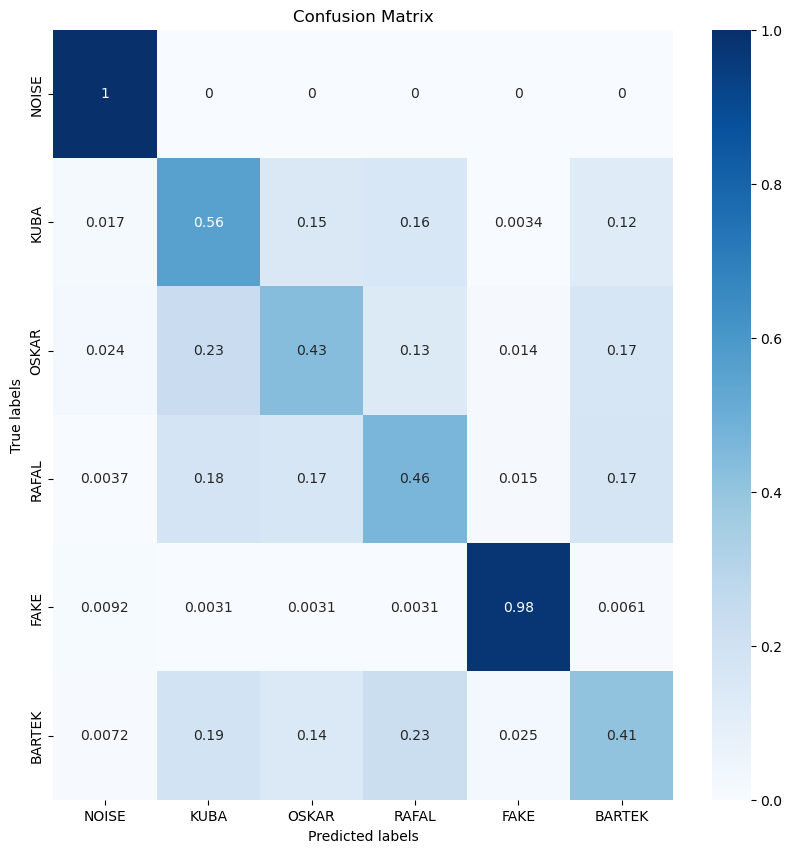

In [14]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = radar_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.show()